<a href="https://colab.research.google.com/github/ImranNust/LungCancerDetection/blob/main/TestingTheFinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <center> <b> <u> Introduction </b> </u></cneter></h1>

<center> <b> In this module, we download the final trained model, compile it, and evaluate it on the test dataset. </center> </b>

**Please Note that it is better to select GPU before running this notebook!!!**

---
<h1> <center> <b> <u> Importing Packages </b> </u></cneter></h1>

<center> <b> First, we will import all the required libraries and packages. </center> </b>

In [1]:
from pathlib import Path
import gdown, os, zipfile, shutil
import tensorflow as tf

from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

In [2]:
try: 
    from utilities.DataProcessing import generate_iterator, display_images
    from utilities.VisionTransformer import PatchExtractor, PatchEncoder, MLP
    from utilities.VisionTransformer import  Block, TransformerEncoder
    from utilities.ConvolutionalNeuralNetworks import CNNLayers, FeatureSelectionBlock, BottleneckBlock
    from utilities.metrics import CustomConfusionMatrix, CustomAccuracy
    from utilities.metrics import CustomPrecision, CustomRecall
    from utilities.metrics import CustomSpecificity, CustomF1Score
    from utilities.plot_metrics import plot_metrics, plot_roc
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find utilties folder... downloading them from GitHub.")
    !git clone https://github.com/ImranNust/LungCancerDetection
    !mv LungCancerDetection/utilities/ .
    # !mv LungCancerDetection/helper_functions.py . # get the helper_functions.py script
    !rm -rf LungCancerDetection
    from utilities.DataProcessing import generate_iterator, display_images
    from utilities.VisionTransformer import PatchExtractor, PatchEncoder, MLP
    from utilities.VisionTransformer import  Block, TransformerEncoder
    from utilities.ConvolutionalNeuralNetworks import CNNLayers, FeatureSelectionBlock, BottleneckBlock
    from utilities.metrics import CustomConfusionMatrix, CustomAccuracy
    from utilities.metrics import CustomPrecision, CustomRecall
    from utilities.metrics import CustomSpecificity, CustomF1Score
    from utilities.plot_metrics import plot_metrics, plot_roc

[INFO] Couldn't find utilties folder... downloading them from GitHub.
Cloning into 'LungCancerDetection'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 135 (delta 31), reused 0 (delta 0), pack-reused 83
Receiving objects: 100% (135/135), 650.23 KiB | 20.97 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [3]:
try:
    import tensorflow_addons as tfa
except:
    print('INFO: tenorflow_addons does not exist; therefore, installing it.')
    !pip install -U tensorflow-addons
    import tensorflow_addons as tfa


learning_rate = 0.00001 # original was 0.0001, and changed to 0.00001
weight_decay = 0.000001 # original was 0.00001 and changed to 0.000001
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

INFO: tenorflow_addons does not exist; therefore, installing it.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.1 MB/s 


---

<h1> <center> <b> <u> Hyperparameter Setting </b> </u></cneter></h1>

<center> <b> Let's set the values for some parameters </center> </b>

In [4]:
# Parameters Setting
num_of_classes = 3
batch_size = 32
projection_dim = 768
target_size = (256, 256)
input_shape = (256, 256, 3)
patch_size = 16
data_dir = Path('DatasetFor32BatchSize') / 'test'
model_checkpoint = Path('BestModel') / 'best_model_checkpoint.ckpt'
metrics = [CustomAccuracy, CustomRecall, CustomPrecision, CustomSpecificity, CustomF1Score]

---

<h1> <center> <b> <u> Downloading the Best Model and the Dataset </b> </u></cneter></h1>

<center> <b> Let's download the best model and the dataset for testing </center> </b>

In [5]:
model_url = 'https://drive.google.com/uc?id=1SOAtYRK_24gXkPOHGk25awxaXJuvw-yP&confirm=t'
dataset_url = 'https://drive.google.com/uc?id=1DbhklhlIuHKTMKGsCjYgnNyGgk2MuGkE&confirm=t'
gdown.download(dataset_url, quiet=False)
gdown.download(model_url, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1DbhklhlIuHKTMKGsCjYgnNyGgk2MuGkE&confirm=t
To: /content/DatasetFor32BatchSize.zip
100%|██████████| 184M/184M [00:04<00:00, 41.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SOAtYRK_24gXkPOHGk25awxaXJuvw-yP&confirm=t
To: /content/BestModel.zip
100%|██████████| 1.60G/1.60G [00:35<00:00, 45.7MB/s]


'BestModel.zip'

In [6]:
if os.path.isfile('BestModel.zip'):
    # Unzip the downloaded data
    with zipfile.ZipFile("BestModel.zip", "r") as zip_ref:
        print("Uzipping the data...")
        zip_ref.extractall(Path(os.getcwd()))
        # Remove the zip file
        os.remove('BestModel.zip')
else:
    print('Either the zip folder doesnot exist, OR you have already extracted it.')

Uzipping the data...


In [7]:
if os.path.isfile('/content/DatasetFor32BatchSize.zip'):
    # Unzip the downloaded data
    with zipfile.ZipFile("DatasetFor32BatchSize.zip", "r") as zip_ref:
        print("Uzipping the data...")
        zip_ref.extractall(Path(os.getcwd()))
        # Remove the zip file
        os.remove('DatasetFor32BatchSize.zip')
        shutil.rmtree('DatasetFor32BatchSize/train')
        shutil.rmtree('DatasetFor32BatchSize/val')
else:
    print('Either the zip folder doesnot exist, OR you have already extracted it.')

Uzipping the data...


---
<h1> <center> <b> <u> Defining the Final Model </b> </u></cneter></h1>

<center> <b> Let's define the CNN and Transfromer Based Model. </center> </b>

In [8]:
# Defining the Model
def final_model(input_shape, 
                patch_size,
                filters = 16,
                kernel_size = 3,
                Normalization = 'layer_normalization', 
                num_classes = num_of_classes,
                dropout_rate = 0.1,
                batch_size = batch_size):
    
    inputs = Input(shape = input_shape)
    
    ############################### Layer 0 #################################
    Layer0_PE = PatchExtractor(patch_size= patch_size,
                               batch_size = batch_size,
                               input_shape = input_shape)
    Layer0_PE_Output = Layer0_PE(inputs)

    
    ############################### Layer 1 ##################################
    Layer1_RB_Output = FeatureSelectionBlock(inputs, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer1_TB_Output = BottleneckBlock(Layer1_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer1_PE = PatchExtractor(patch_size= patch_size//2,
                               batch_size = batch_size,
                               input_shape = Layer1_TB_Output.shape[1:])
    Layer1_PE_Output = Layer1_PE(Layer1_TB_Output)

    
    ############################### Layer 2 ##################################
    Layer2_RB_Output = FeatureSelectionBlock(Layer1_TB_Output, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer2_TB_Output = BottleneckBlock(Layer2_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer2_PE = PatchExtractor(patch_size= patch_size//4,
                               batch_size = batch_size,
                               input_shape = Layer2_TB_Output.shape[1:])
    Layer2_PE_Output = Layer2_PE(Layer2_TB_Output)

    ############################### Layer 3 ##################################
    
    Layer3_RB_Output = FeatureSelectionBlock(Layer2_TB_Output, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer3_TB_Output = BottleneckBlock(Layer3_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer3_PE = PatchExtractor(patch_size= patch_size//8,
                               batch_size = batch_size,
                               input_shape = Layer3_TB_Output.shape[1:])
    Layer3_PE_Output = Layer3_PE(Layer3_TB_Output)

    ############################### Layer 4 ##################################
    Layer4_RB_Output = FeatureSelectionBlock(Layer3_TB_Output, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer4_TB_Output = BottleneckBlock(Layer4_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer4_PE = PatchExtractor(patch_size= patch_size//16,
                               batch_size = batch_size,
                               input_shape = Layer4_TB_Output.shape[1:])
    Layer4_PE_Output = Layer4_PE(Layer4_TB_Output)
    concatenate_output = tf.keras.layers.Concatenate(axis = -1)([Layer0_PE_Output,
                                                                 Layer1_PE_Output, 
                                                                 Layer2_PE_Output,
                                                                 Layer3_PE_Output,
                                                                 Layer4_PE_Output])
    Layer4_PEncoder = PatchEncoder(patch_size = patch_size,
                                   batch_size = batch_size,
                                   input_shape = input_shape)
    
    Layer4_PEncoder_Output = Layer4_PEncoder(concatenate_output)
    
    input_for_transformer = Layer4_PEncoder_Output
    
    ########################## Transformormer Layer #############################
    transformer1 = TransformerEncoder(patch_size = patch_size,
                                      batch_size = batch_size,
                                      input_shape = input_shape,
                                      num_heads = 4,
                                      num_blocks = 12,
                                      dropout_rate = 0.1)
    transformer1_output = transformer1(input_for_transformer)
    
    output = GlobalAveragePooling1D()(transformer1_output)
    
    # MLP to classify outputs
    mlp = MLP(projection_dim, 128, dropout_rate = dropout_rate)
    logits = mlp(output)
    # # Create model
    outputs = Dense(num_classes, activation='softmax')(logits)
    model = Model(inputs = inputs, outputs = outputs)
    return model




---

<h1> <center> <b> <u> Loading Weights and Evaluating the Model </b> </u></cneter></h1>

<center> <b> Here, we will load build the model, compile it, load the best weights, and evaluate it using the test dataset. </center> </b>

In [9]:
model = final_model(input_shape = input_shape, 
                    patch_size = patch_size,
                    filters = 16,
                    kernel_size = 3,
                    Normalization = 'layer_normalization',     
                    num_classes = num_of_classes,
                    dropout_rate = 0.1)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics= metrics)
model.load_weights(model_checkpoint)

test_iterator = generate_iterator(path = data_dir, augmentation = False, color_mode = 'rgb', 
                                   batch_size = batch_size, shuffle = True, target_size = target_size,
                                   seed = None, interpolation = 'bilinear', rescale = 1/255.0)


test_results = model.evaluate(test_iterator)

Generating the iterator without performing augmenation...
Found 1440 images belonging to 3 classes.
45/45 [==============================] - 122s 2s/step - loss: 0.0482 - CustomAccuracy: 0.9889 - CustomRecall: 0.9832 - CustomPrecision: 0.9844 - CustomSpecificity: 0.9915 - CustomF1Score: 0.9829


---

<h1> <center> <b> <u> Prediction </b> </u></cneter></h1>

<center> <b> Let's predict a few images using the trained model. </center> </b>

1/1 [==============================] - 5s 5s/step


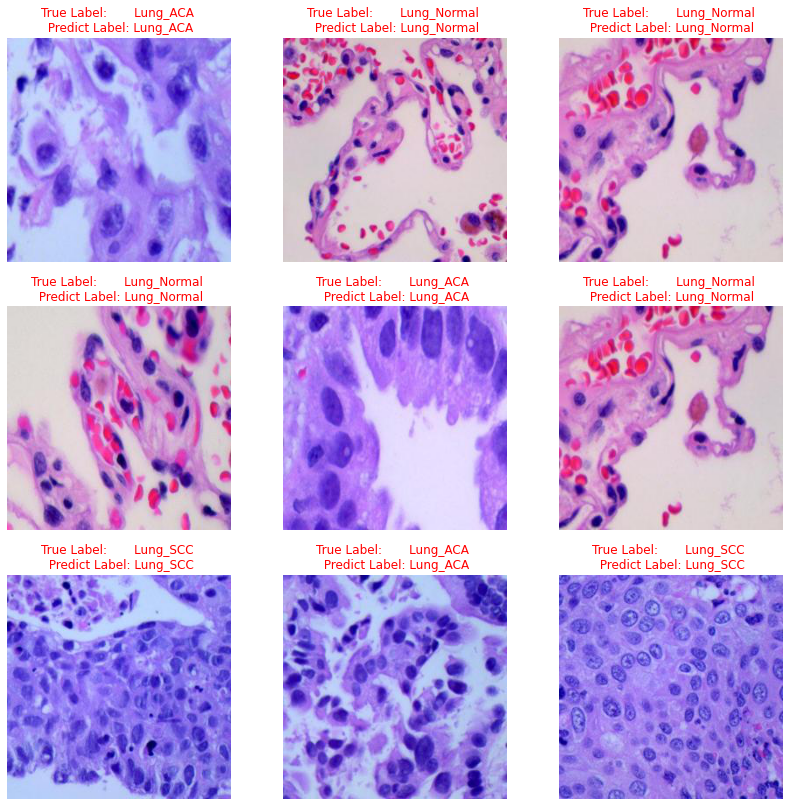

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
test_images, true_labels = test_iterator.next()
pred_labels = model.predict(test_images)
classes = list(test_iterator.class_indices)
plt.figure(figsize = (14, 14))
for i in range(0, 9):
    rnd_img = np.random.choice(32)
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[rnd_img,...])
    text = 'True Label:       {} \n Predict Label: {}'.format(classes[np.argmax(true_labels[rnd_img])], classes[np.argmax(pred_labels[rnd_img])])
    plt.title(text, color = 'red')
    plt.axis(False)